In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevels = percents = [0.1, 0.01]

alpha = 1 # proximal term coefficient


num_resources = 50
num_agents = num_participants = 100

filename = "local_resal_N%d_%s_n%d_m%d"%(num_points, ",".join(list(map(str, eps_sublevels))), num_agents, num_resources)

In [4]:

num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
true_x, true_f, true_lamb = mra.centralized_solution_resal(A_all, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-91.86415947259077


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.000000020813085

In [7]:
true_lamb.shape, true_x.shape

((50, 1), (5000, 1))

In [8]:
fun_agents_eps = {}
fun_agents_noisy_y = {}
for eps in percents:
    fun_agents_eps[eps] = []
    fun_agents_noisy_y[eps] = []
    for i in range(num_agents):
        fun_agents_eps[eps] += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions(lamb_k, i, A_all, 
                                                                           eps_sublevel=eps, K=K, return_best=True)]
        fun_agents_noisy_y[eps] += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions_noisy_prices(lamb_k, i, A_all,
                                                                        percent=eps, K=K)]


fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# Localization

In [9]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
alpha = 1 # proximal term coefficient
K_i = num_points
N = num_agents
primal_var_size = A.shape[1]

In [10]:
all_results_eps = {}
all_results_noisy_y = {}
for eps in percents:
    print(f"{eps=}")
    all_results_eps[eps]  = mra.price_localization_primal_recovery(fun_agents_eps[eps], fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[eps]  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

eps=0.1
epoch=0, f_prec[-1]=-91.19, f_xk[-1]=-98.99, viol_prec=2.9336E+02, viol_xk=4.2108E+02, lamb_rel_diff=0.0000E+00,thetas[-1]=8.6088E-08, dist_x_bar_x[-1]=1.1763E+00
epoch=50, f_prec[-1]=-90.61, f_xk[-1]=-98.99, viol_prec=8.4089E+00, viol_xk=1.1819E+02, lamb_rel_diff=1.4778E-01,thetas[-1]=1.9630E-08, dist_x_bar_x[-1]=1.3187E+00
epoch=100, f_prec[-1]=-91.49, f_xk[-1]=-95.60, viol_prec=1.1907E+00, viol_xk=6.5719E+01, lamb_rel_diff=5.8679E-02,thetas[-1]=1.2682E-08, dist_x_bar_x[-1]=1.1494E+00
epoch=150, f_prec[-1]=-91.62, f_xk[-1]=-92.48, viol_prec=1.7901E-01, viol_xk=2.7223E+01, lamb_rel_diff=1.5109E-02,thetas[-1]=1.0898E-01, dist_x_bar_x[-1]=9.2694E-01
epoch=199, f_prec[-1]=-91.72, f_xk[-1]=-92.06, viol_prec=2.6886E-02, viol_xk=8.6204E+00, lamb_rel_diff=7.9546E-03,thetas[-1]=1.5052E-01, dist_x_bar_x[-1]=6.9009E-01
epoch=0, f_prec[-1]=-98.46, f_xk[-1]=-98.99, viol_prec=4.0431E+02, viol_xk=4.2108E+02, lamb_rel_diff=0.0000E+00,thetas[-1]=8.8629E-06, dist_x_bar_x[-1]=7.3480E-01
epoch=5

In [11]:
eps = max(percents)
if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
    all_res = all_results_noisy_y[eps]
else:
    all_res = all_results_eps[eps]

In [20]:
for i, eps in enumerate(percents):
      print(np.array(all_res["viol_primal_xk"])[-1] / b_norm,
      "sub_eps", np.array(all_results_eps[eps]["viol_primal_mra_xk"])[-1] / b_norm,
      "noisy_y", np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"])[-1] / b_norm)

0.03179387091112002 sub_eps 2.489915063407188e-12 noisy_y 3.126078509948249e-11
0.03179387091112002 sub_eps 4.242500435430708e-12 noisy_y 4.832468633899172e-13


In [ ]:
import pickle

with open(f"results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [6]:
import pickle

# with open(f"results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    eps = max(percents)
    if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
        all_res = all_results_noisy_y[eps]
    else:
        all_res = all_results_eps[eps]
# res["eps"].keys()

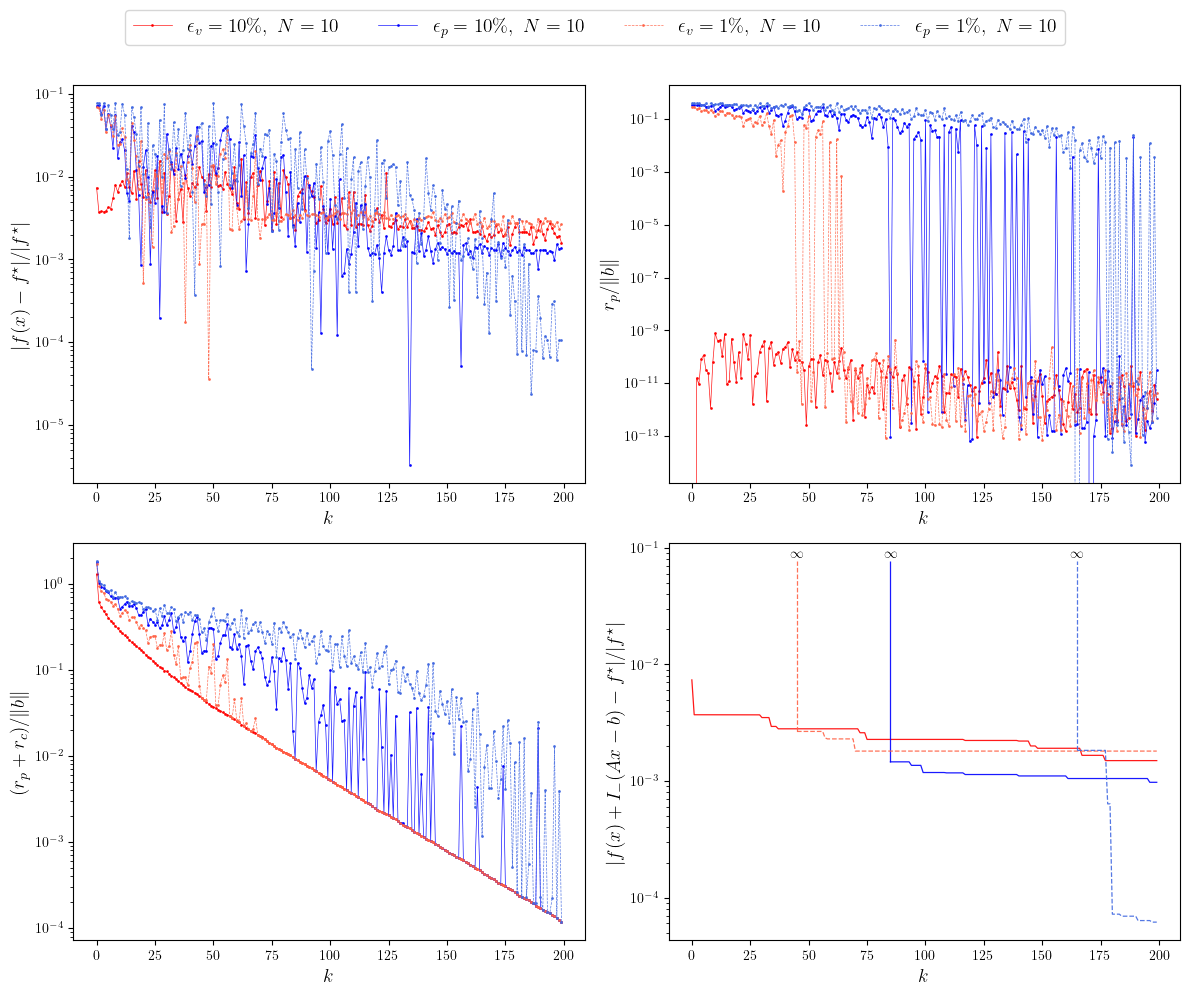

In [8]:
mra.plot_eps_all_metrics_4x(all_results_eps, all_results_noisy_y, num_points, true_f, b_norm, percents, filename)

In [9]:
for eps in percents:
    print(f"{eps=}")
    eps_subopt = (np.abs(np.array(all_results_eps[eps]["f_prec"]) - true_f)) / np.abs(true_f)
    eps_res = np.array(all_results_eps[eps]["viol_primal_mra_xk"]) / b_norm
    noisy_y_subopt = (np.abs(np.array(all_results_noisy_y[eps]["f_prec"]) - true_f)) / np.abs(true_f)
    noisy_y_res = np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"]) / b_norm

    res_tol = 1e-6
    print("eps", np.where(eps_res < res_tol)[0][0],  "noisy_y", np.where(noisy_y_res < res_tol)[0][0])

    eps_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_eps[eps], true_f, b_norm),)
    noisy_y_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_noisy_y[eps], true_f, b_norm),)

    print("eps", eps_subopt[-1]*100,  "noisy_y", noisy_y_subopt[-1]*100)

eps=0.1
eps 0 noisy_y 85
eps 0.14965178485433125 noisy_y 0.0975151469408884
eps=0.01
eps 45 noisy_y 165
eps 0.18062196464685615 noisy_y 0.00616366901076421
